<a href="https://colab.research.google.com/github/SoumyaShreeram/Microlensing_with_NeuralNets/blob/master/03_Optimizing_and_testing_NNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Testing Neural Network Architecture

Author: Soumya Shreeram <br>
Script adapted from: Millon Martin & Kevin Müller <br>
Date: 23rd February 2020

Import all required python libraries

In [0]:
from google.colab import drive
import os
import pickle
import importlib
import itertools

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import random
import os
from IPython.display import Image, SVG

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, InputSpec
from tensorflow.python.keras.layers import Conv1D, Conv2D
from tensorflow.python.keras.layers import MaxPooling1D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Add, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

Mount google drive

In [2]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Directory where the `python` files are stored on Google Drive. These imported files are also available in `.ipynb` format on the GitHub repo with same names (without the dr; <strike>`dr`</strike>`0X_sameFileName`). dr stands for drive. 

In [0]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks')

import dr02_preprocessing_data as dat
import dr04_neural_network_designs as nnet

Setting up the path to the data directory

In [0]:
current_dir = os.getcwd()
data_dir = r'/content/gdrive/My Drive/training_set_microlensing/'
save_image_dir = r'/content/gdrive/My Drive/Colab Notebooks/Images'

### 1. Input parameters

In [54]:
v_t = [500, 300] # transverse velcity
v_t_idx = 0 # choose index value for the velocity you would like (0 or 1)
r_0 = (2,4,10,15,20,30,40,60,80,100) # scale radius
output_class_names = [str(r) for r in r_0 ]
# reloads the file if any changes are made in the methods
importlib.reload(dat)

<module 'dr02_preprocessing_data' from '/content/gdrive/My Drive/Colab Notebooks/dr02_preprocessing_data.py'>

### 2. Load the data

There are 10 categories into which the light-curves are classified. Each category is represented by the scale radius `r_0`. For every scale radius, there exists a light-curve whose data points are stored in the 3D array `l_curves`.

In [0]:
# sets the sampling parameters
sample_params = dat.setSamplingParameters(v_t[v_t_idx], data_dir, euler_sampling=True)

# initializes data arrays
class_cat, l_curves, out_catergories, out_radii = dat.initializer(r_0, sample_params)

for i, rad in enumerate(r_0):
  filename = dat.getFilename(data_dir, rad, v_t[v_t_idx], sample_params)
  
  # load data from the file
  l_curves = dat.loadData(filename, l_curves, sample_params, i)
  out_catergories[i*sample_params[0]:(i+1)*sample_params[0]] = class_cat[1][i]
  out_radii[i*sample_params[0]:(i+1)*sample_params[0]] = r_0[i]

#### 2.1 Plots of some random light-curves

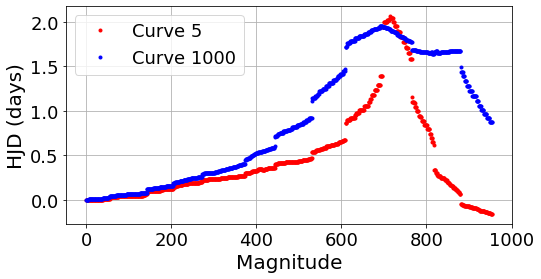

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
n = [5, 1000]
ax.plot(l_curves[n[0], :], 'r.', label='Curve %i'%(n[0]))
ax.plot(l_curves[n[1], :], 'b.', label='Curve %i'%(n[1]))
dat.setLabels(ax, 'Magnitude', 'HJD (days)', ticks=True, legend=True)

### 3. Generate training and testing data sets

In [0]:
train_l_curves, test_l_curves, data_sets, onehot_train, \
onehot_test = dat.generateTestTrain(l_curves, out_catergories, out_radii, r_0)

### 4. Compiling the 3 networks

The three networks compiled here are coded in `04_Neural_Network_Designs.ipynb` that have been saved as `dr04_Neural_Network_Designs.py`, for ease of importing it. The python files can be found in the GitHub repo folder *python files*. 

Note that if you are running this from colab, need to have these `.py` files in your drive folder *Colab Notebooks*. 

Default constants that can be modified.

In [95]:
# choose which network to use (default CNN2)
CNN1, CNN2, ResNet = False, False, True

model_types = [CNN1, CNN2, ResNet]
model_name_list = ['CNN1','CNN2','ResNet']

for i in range(len(model_name_list)):
  if model_types[i]:
    model_name = model_name_list[i]
print('Using the Neural Network:', model_name)

Using the Neural Network: True


The following code block uses the methods defined in the file `dr04_Neural_Network_Designs.py`: imported as **`nnet`**

Model parameters are defined in the methods in **`nnet`** additionally some more details:
* `num_hidden_nodes`: number of nodes in hidden fully connected layer
*`dropout_ratio`: % of nodes in the hidden layer to dropout during back-propagation update of the network weights

#### 4.1 Compiling CNN2

In [11]:
if CNN2:
  # reloads the file if any changes are made
  importlib.reload(nnet)

  """--- CNN2 Model Parameters ---"""
  num_filter = (32, 32, 44, 44)
  kern_size = (21,21,15,15)
  maxpoolsize = (None, 15, None, 15)
  shortcut_link = (0,1,2,3)
  batch_norm = False
  num_hidden_nodes = [1500]
  dropout_ratio = 0.4  
  sampling = 3
  num_pieces = 1
  
  # prepare the data
  data_prep = nnet.prepare_data_sample_cut(test_l_curves, sampling, num_pieces)

  # build the model
  inputs, outputs = nnet.buildModelCNN2(sample_params[2], num_filter, kern_size, \
                                        maxpoolsize, num_hidden_nodes,\
                                        dropout_ratio, shortcut_link, batch_norm, \
                                        data_prep.shape[1], r_0)

  # compile the model
  # optimisation algorithm, loss (cost) function
  optimizer_type = Adam(lr=5e-4)  
  loss = 'categorical_crossentropy'  
  #accuracy metric to be determined after each epoch 
  metrics = ['categorical_accuracy'] 

  model = nnet.compileDisplayNetwork(inputs, outputs, optimizer_type, loss, \
                                    metrics, 'CNN2', True)

  print('Network created')

(319,)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 318, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 318, None, 44 704         input_1[0][0]                    
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 318, None, 44 0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation_

#### 4.2 Compiling ResNet

In [0]:
if ResNet:
  # reloads the file if any changes are made
  importlib.reload(nnet)

  """--- ResNet Model Parameters ---"""
  num_filter = (32, 32, 32)
  kern_size = (10,20,50)
  n_block = 5
  maxpoolsize = 3
  num_hidden_nodes =[1000.0,]
  dropout_ratio = 0.7 
  batch_norm = True
  #If they are not 1, this network is not correctly defined.
  sampling = 1
  num_pieces = 1

  # build network
  inputs, outputs = nnet.defineResnet(sample_params[2], num_filter, \
                                           kern_size, n_block,maxpoolsize,\
                                           num_hidden_nodes, dropout_ratio, r_0,\
                                           batch_norm = batch_norm)
  
  learning_rate = 1e-4
  decay_rate = 0.0
  optimizer_type = Adam(lr=learning_rate, decay = decay_rate)  
  loss = 'categorical_crossentropy'  
  metrics = ['categorical_accuracy'] 

  model = nnet.compileDisplayNetwork(inputs, outputs, optimizer_type, loss, \
                                     metrics, 'ResNet', True)
  
  #model.load_weights('/content/gdrive/My Drive/Colab_Notebooks/Deep_learning_for_optical_IMaging/Resnet_weights.h5')

  print('Network created')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 955, None, 1 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 955, None, 32 352         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 955, None, 32 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 955, None, 32 20512       activation[0][0]                 
_____________

### 5. Training the network

Constants used for training the network

In [0]:
validtrain_split_ratio = 0.2  # % of the seen dataset to be put aside for validation, rest is for training
max_epochs = 30  # maxmimum number of epochs to be iterated
batch_size = 60   # batch size for the training data set
num_inputs = 1

In [14]:
if sampling == 1 and num_pieces == 1:
  model, history = nnet.fit_model_generator(model, train_l_curves, onehot_train, \
                    num_inputs = num_inputs, batch_size = batch_size, \
                    epochs = max_epochs, validation_split = validtrain_split_ratio, \
                    verbose = 1)
else:
  data_prep = nnet.prepare_data_sample_cut(train_l_curves, sampling, num_pieces)

  model, history = nnet.fit_model_generator(model, data_prep, onehot_train, \
                    num_inputs = num_inputs, batch_size = batch_size, \
                    epochs = max_epochs, validation_split = validtrain_split_ratio, \
                    verbose = 1)

print('Training completed')

(319,)
Train on 64000 samples, validate on 16000 samples
Epoch 1/30
64000/64000 [==============================] - 37s 572us/sample - loss: 2.3398 - categorical_accuracy: 0.1275 - val_loss: 2.2133 - val_categorical_accuracy: 0.1482
Epoch 2/30
64000/64000 [==============================] - 35s 549us/sample - loss: 2.2050 - categorical_accuracy: 0.1536 - val_loss: 2.1644 - val_categorical_accuracy: 0.1694
Epoch 3/30
64000/64000 [==============================] - 35s 551us/sample - loss: 2.1635 - categorical_accuracy: 0.1670 - val_loss: 2.1412 - val_categorical_accuracy: 0.1724
Epoch 4/30
64000/64000 [==============================] - 35s 552us/sample - loss: 2.1452 - categorical_accuracy: 0.1698 - val_loss: 2.1311 - val_categorical_accuracy: 0.1751
Epoch 5/30
64000/64000 [==============================] - 36s 562us/sample - loss: 2.1318 - categorical_accuracy: 0.1740 - val_loss: 2.1146 - val_categorical_accuracy: 0.1817
Epoch 6/30
64000/64000 [==============================] - 35s 546us/

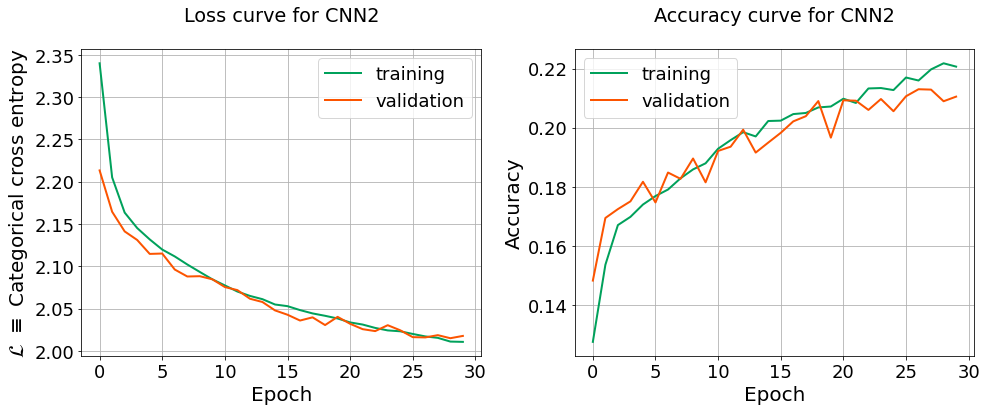

In [45]:
# plots the history
fig, ax = plt.subplots(1,2, figsize=(14,6))
labels = ['training', 'validation']
loss_Accuracy = ['loss', 'val_loss', 'categorical_accuracy', 'val_categorical_accuracy']

dat.plotLoss(ax[0], history, loss_Accuracy, model_name, labels)
dat.plotAccuracy(ax[1], history, loss_Accuracy, model_name, labels)
 
fig.savefig(save_image_dir+'/LandA_%s.png'%model_name)    
fig.tight_layout()

### 6. Displaying the classification report, confusion matrix

In [68]:
num_inputs = 1

# prepare data with sample cuts and evaluate residuals
data_prep = nnet.prepare_data_sample_cut(test_l_curves, sampling, num_pieces)
evaluate_res = nnet.evaluate_model(model, data_prep, onehot_test, \
                                num_inputs = num_inputs, verbose = 1)

print(evaluate_res[1])

output_predict_onehot, output_ref_onehot = nnet.predict_model(model, data_prep, \
                                                              onehot_test, \
                                                              num_inputs = num_inputs, \
                                                              verbose = 1)
output_predict_c = np.argmax(output_predict_onehot, axis=1)
output_ref_c = np.argmax(output_ref_onehot, axis=1)

print('Test set classification report:\n')
print(classification_report(output_ref_c, output_predict_c,  \
                            target_names=output_class_names))

(319,)
20000/20000 [==============================] - 5s 231us/sample - loss: 2.0265 - categorical_accuracy: 0.2064
0.2064
20000/20000 [==============================] - 4s 224us/sample
Test set classification report:

              precision    recall  f1-score   support

           2       0.55      0.56      0.56      2006
           4       0.30      0.33      0.32      2065
          10       0.18      0.29      0.22      2042
          15       0.14      0.08      0.10      2009
          20       0.14      0.08      0.10      1956
          30       0.12      0.08      0.10      2014
          40       0.13      0.26      0.17      1974
          60       0.14      0.07      0.10      1961
          80       0.15      0.14      0.15      1943
         100       0.16      0.15      0.15      2030

    accuracy                           0.21     20000
   macro avg       0.20      0.21      0.20     20000
weighted avg       0.20      0.21      0.20     20000



/content/gdrive/My Drive/Colab Notebooks/dr02_preprocessing_data.py:191: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(tick_marks, output_class_names)
/content/gdrive/My Drive/Colab Notebooks/dr02_preprocessing_data.py:192: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_yticks(tick_marks, output_class_names)


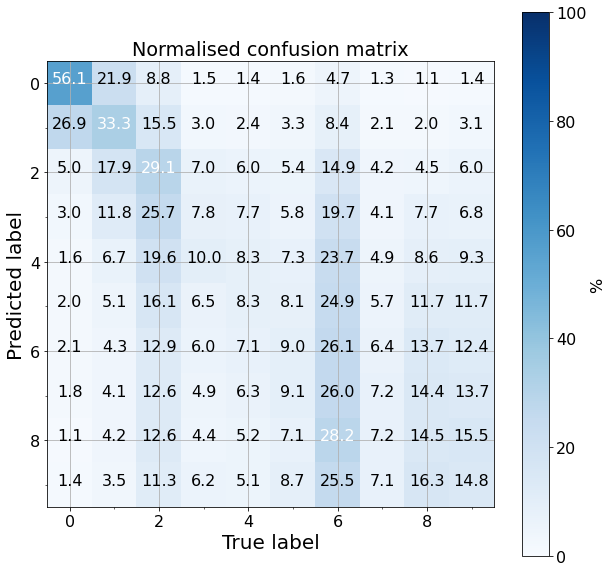

In [94]:
from sklearn.metrics import confusion_matrix

importlib.reload(dat)
# generate confusion matrix
cfm = confusion_matrix(output_ref_c, output_predict_c)  

# row normalisation of confusion matrix
cfm_probability = cfm.astype('float')/cfm.sum(axis=1)[:, np.newaxis]  
# confusion probability matrix
cfm_probability = cfm_probability * 100.0  

fig, ax = plt.subplots(1,1, figsize=(10,10))
dat.plotConfusionMatrix(ax, cfm_probability, output_class_names)